<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week7%20/DeepRNN/DeepRNN_Sarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


<ipython-input-4-be49d0a1371f>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# 1. Data Loading and Exploration
print("Loading data...")
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
df = pd.read_json(url, lines=True)
print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

Loading data...
Dataset shape: (26709, 3)

Sample data:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [7]:
# 2. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
article_link    0
headline        0
is_sarcastic    0
dtype: int64


In [8]:
# 3. Check class distribution
print("\nClass distribution:")
print(df['is_sarcastic'].value_counts())
print(df['is_sarcastic'].value_counts(normalize=True).round(3))



Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64
is_sarcastic
0    0.561
1    0.439
Name: proportion, dtype: float64


In [9]:
# 4. Text Preprocessing
def clean_text(text):
    """Basic text preprocessing function"""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

In [10]:
# Apply the cleaning function
df['clean_headline'] = df['headline'].apply(clean_text)


In [11]:
# Check text length distribution
text_lengths = df['clean_headline'].str.split().str.len()
print(f"\nHeadline length statistics:")
print(f"Mean: {text_lengths.mean():.2f} words")
print(f"Median: {text_lengths.median()} words")
print(f"95th percentile: {text_lengths.quantile(0.95)} words")
print(f"Max: {text_lengths.max()} words")



Headline length statistics:
Mean: 9.83 words
Median: 10.0 words
95th percentile: 15.0 words
Max: 39 words


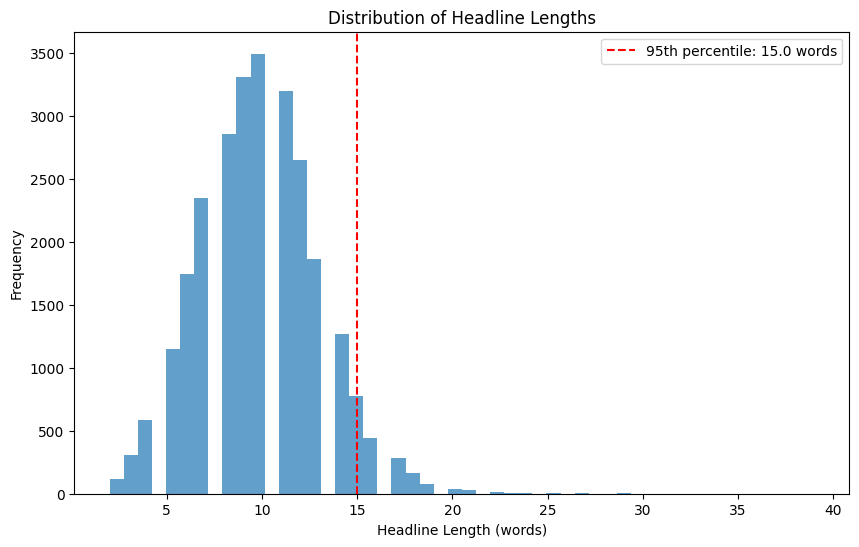

In [12]:
# Plot headline length distribution
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, alpha=0.7)
plt.axvline(x=text_lengths.quantile(0.95), color='r', linestyle='--',
            label=f'95th percentile: {text_lengths.quantile(0.95)} words')
plt.xlabel('Headline Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Headline Lengths')
plt.legend()
plt.savefig('headline_length_distribution.png')
plt.show()

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_headline'],
    df['is_sarcastic'],
    test_size=0.2,
    random_state=42,
    stratify=df['is_sarcastic']
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Training set size: 21367
Testing set size: 5342


In [14]:
# 5. Text Tokenization
max_words = 10000  # Maximum number of words in vocabulary
max_len = 30  # Based on the 95th percentile of headline lengths

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


In [15]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [16]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [17]:
# Check vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")


Vocabulary size: 25545


In [18]:
# 6. Build Deep RNN Model
def build_deep_rnn_model(hp=None):
    # Default hyperparameters if not tuning
    embedding_dim = 200 if hp is None else hp.Int('embedding_dim', min_value=100, max_value=300, step=50)
    rnn_units_1 = 128 if hp is None else hp.Int('rnn_units_1', min_value=64, max_value=256, step=64)
    rnn_units_2 = 96 if hp is None else hp.Int('rnn_units_2', min_value=32, max_value=128, step=32)
    rnn_units_3 = 64 if hp is None else hp.Int('rnn_units_3', min_value=16, max_value=96, step=16)
    dropout_rate_1 = 0.3 if hp is None else hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)
    dropout_rate_2 = 0.3 if hp is None else hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)
    dropout_rate_3 = 0.3 if hp is None else hp.Float('dropout_rate_3', min_value=0.2, max_value=0.5, step=0.1)
    dense_units = 32 if hp is None else hp.Int('dense_units', min_value=16, max_value=64, step=16)
    learning_rate = 0.001 if hp is None else hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    rnn_type = 'lstm' if hp is None else hp.Choice('rnn_type', values=['lstm', 'gru'])

    model = Sequential()
    model.add(Embedding(min(vocab_size, max_words), embedding_dim, input_length=max_len))
    model.add(Dropout(dropout_rate_1))

    # First RNN layer
    if rnn_type == 'lstm':
        model.add(LSTM(rnn_units_1, return_sequences=True))
    else:
        model.add(GRU(rnn_units_1, return_sequences=True))
    model.add(Dropout(dropout_rate_1))

    # Second RNN layer
    if rnn_type == 'lstm':
        model.add(LSTM(rnn_units_2, return_sequences=True))
    else:
        model.add(GRU(rnn_units_2, return_sequences=True))
    model.add(Dropout(dropout_rate_2))

    # Third RNN layer
    if rnn_type == 'lstm':
        model.add(LSTM(rnn_units_3))
    else:
        model.add(GRU(rnn_units_3))
    model.add(Dropout(dropout_rate_3))

    # Output layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate_3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
# 7. Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_sarcasm_deep_rnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [21]:
# 8. Train the initial model
print("\nTraining basic Deep RNN model...")
history = model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


Training basic Deep RNN model...
Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6103 - loss: 0.6435
Epoch 1: val_accuracy improved from -inf to 0.81844, saving model to best_sarcasm_deep_rnn_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6110 - loss: 0.6429 - val_accuracy: 0.8184 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8547 - loss: 0.3489
Epoch 2: val_accuracy improved from 0.81844 to 0.84464, saving model to best_sarcasm_deep_rnn_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8549 - loss: 0.3486 - val_accuracy: 0.8446 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9200 - loss: 0.2305
Epoch 3: val_accuracy did not improve from 0.84464

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9201 - loss: 0.2303 - val_accuracy: 0.8411 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 4/15
131/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9553 - loss: 0.1431
Epoch 4: val_accuracy did not improve from 0.84464
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9554 - loss: 0.1428 - val_accuracy: 0.8407 - val_loss: 0.5334 - learning_rate: 5.0000e-04
Epoch 5/15
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9580 - loss: 0.1310
Epoch 5: val_accuracy did not improve from 0.84464

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
13

In [23]:
# 9. Evaluate the initial model
print("\nEvaluating the model...")
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nInitial Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")


Evaluating the model...
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Initial Model Performance:
Accuracy: 0.8169
Precision: 0.8825
Recall: 0.6725
F1 Score: 0.7633
AUC-ROC: 0.9154


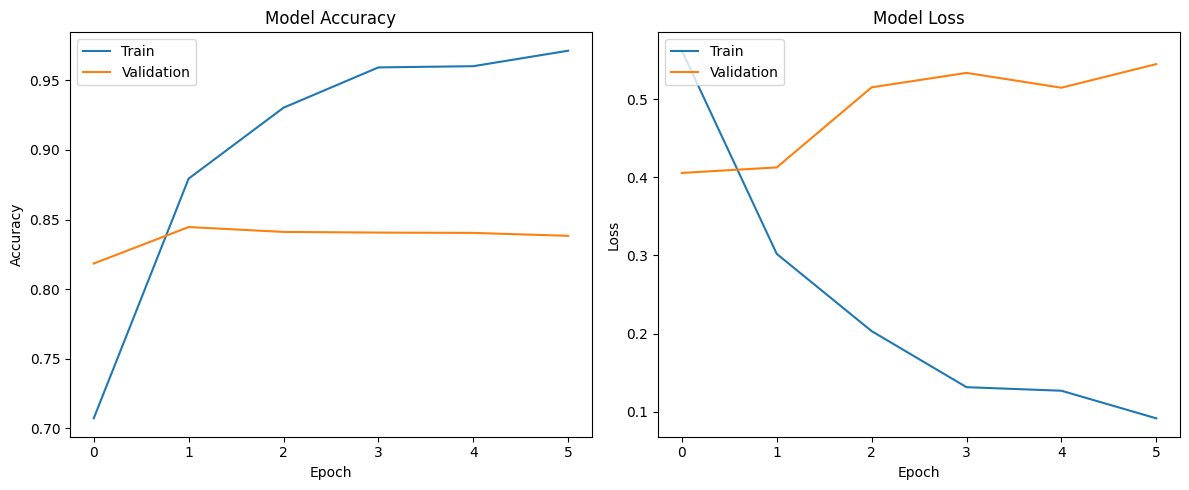

In [24]:
# 10. Visualizations
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('sarcasm_deep_rnn_training_metrics.png')
plt.show()


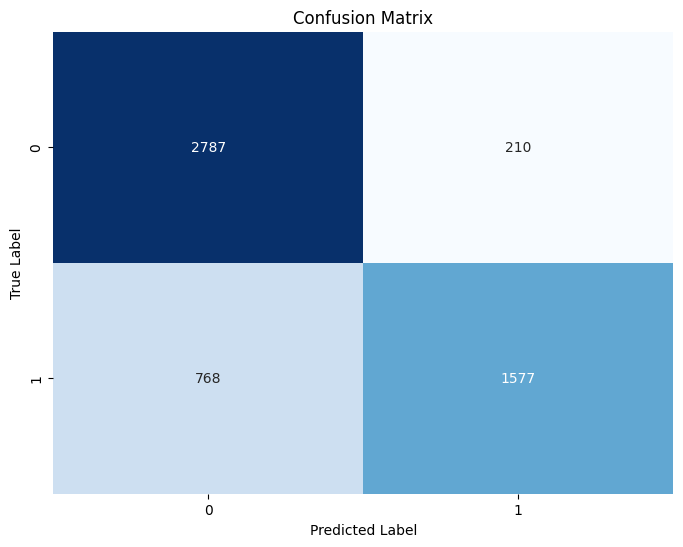

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('sarcasm_deep_rnn_confusion_matrix.png')
plt.show()

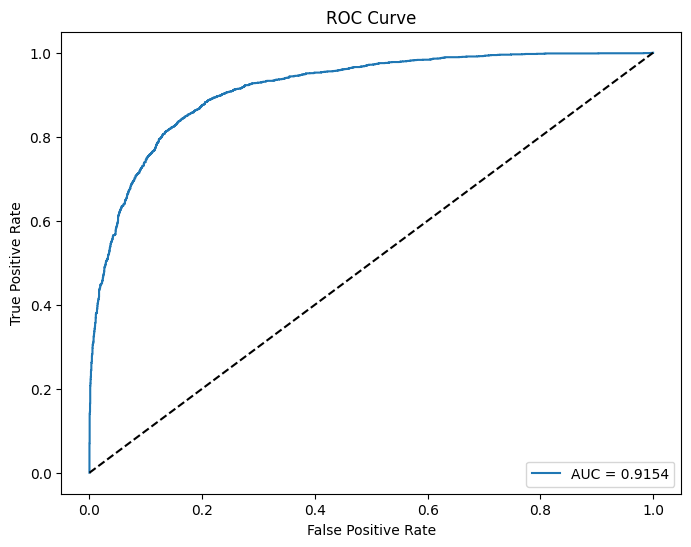

In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('sarcasm_deep_rnn_roc_curve.png')
plt.show()

In [27]:
# 11. Hyperparameter Tuning
print("\nStarting hyperparameter tuning...")

def model_builder(hp):
    return build_deep_rnn_model(hp)

tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='sarcasm_deep_rnn_hyperparameter_tuning',
    project_name='sarcasm_detection_deep_rnn'
)

tuner.search(
    X_train_pad, y_train,
    epochs=8,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Trial 10 Complete [00h 00m 24s]
val_accuracy: 0.8488535284996033

Best val_accuracy So Far: 0.8572765588760376
Total elapsed time: 00h 04m 07s


In [28]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest hyperparameters found:")
print(f"RNN Type: {best_hps.get('rnn_type')}")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"RNN Units 1: {best_hps.get('rnn_units_1')}")
print(f"RNN Units 2: {best_hps.get('rnn_units_2')}")
print(f"RNN Units 3: {best_hps.get('rnn_units_3')}")
print(f"Dropout Rate 1: {best_hps.get('dropout_rate_1')}")
print(f"Dropout Rate 2: {best_hps.get('dropout_rate_2')}")
print(f"Dropout Rate 3: {best_hps.get('dropout_rate_3')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")



Best hyperparameters found:
RNN Type: gru
Embedding Dimension: 100
RNN Units 1: 64
RNN Units 2: 32
RNN Units 3: 80
Dropout Rate 1: 0.2
Dropout Rate 2: 0.4
Dropout Rate 3: 0.4
Dense Units: 32
Learning Rate: 0.005


In [29]:
# 12. Train the model with best hyperparameters
print("\nTraining final model with best hyperparameters...")
best_model = tuner.hypermodel.build(best_hps)

# Enhanced callbacks for final training
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

final_checkpoint = ModelCheckpoint(
    'final_sarcasm_deep_rnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

final_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

final_history = best_model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[final_early_stopping, final_checkpoint, final_reduce_lr]
)


Training final model with best hyperparameters...
Epoch 1/20
131/134 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5429 - loss: 0.6889
Epoch 1: val_accuracy improved from -inf to 0.55475, saving model to final_sarcasm_deep_rnn_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5432 - loss: 0.6889 - val_accuracy: 0.5547 - val_loss: 0.6872 - learning_rate: 0.0050
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5613 - loss: 0.6865
Epoch 2: val_accuracy did not improve from 0.55475
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5613 - loss: 0.6864 - val_accuracy: 0.5547 - val_loss: 0.6871 - learning_rate: 0.0050
Epoch 3/20
130/134 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5706 - loss: 0.6790
Epoch 3: val_accuracy improved from 0.55475 to 0.81750, saving model to final_sarcasm_deep_rnn_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5728 - loss: 0.6773 - val_accuracy: 0.8175 - val_loss: 0.4512 - learning_rate: 0.0050
Epoch 4/20
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8353 - loss: 0.3890
Epoch 4: val_accuracy improved from 0.81750 to 0.83973, saving model to final_sarcasm_deep_rnn_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8358 - loss: 0.3882 - val_accuracy: 0.8397 - val_loss: 0.3764 - learning_rate: 0.0050
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9259 - loss: 0.1998
Epoch 5: val_accuracy improved from 0.83973 to 0.84207, saving model to final_sarcasm_deep_rnn_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9260 - loss: 0.1995 - val_accuracy: 0.8421 - val_loss: 0.6856 - learning_rate: 0.0050
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9617 - loss: 0.1147
Epoch 6: val_accuracy did not improve from 0.84207
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9618 - loss: 0.1147 - val_accuracy: 0.8341 - val_loss: 0.6268 - learning_rate: 0.0050
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9705 - loss: 0.0893
Epoch 7: val_accuracy did not improve from 0.84207

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9705 - loss: 0.0893 - val_accuracy: 0.8411 - val_loss: 0.7878 - learning_rate: 0.0050
Epoch 8/20
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9788 - loss: 0.0622
Epoch 8: val_accuracy did not improve from 0.84207
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9788 - loss: 0.0621 - val_a

In [30]:
# 13. Final Evaluation
print("\nFinal evaluation...")
# Load the best model weights
best_model.load_weights('final_sarcasm_deep_rnn_model.h5')

# Evaluate on training set for the 90% requirement check
train_loss, train_accuracy = best_model.evaluate(X_train_pad, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_prob_final = best_model.predict(X_test_pad)
y_pred_final = (y_pred_prob_final > 0.5).astype(int)

# Calculate final evaluation metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_pred_prob_final)

print("\nFinal Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"AUC-ROC: {final_auc:.4f}")



Final evaluation...
Training Accuracy: 0.9306
Test Accuracy: 0.8439
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Final Model Performance:
Accuracy: 0.8439
Precision: 0.8298
Recall: 0.8107
F1 Score: 0.8201
AUC-ROC: 0.9177


In [31]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2997
           1       0.83      0.81      0.82      2345

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.84      0.84      0.84      5342



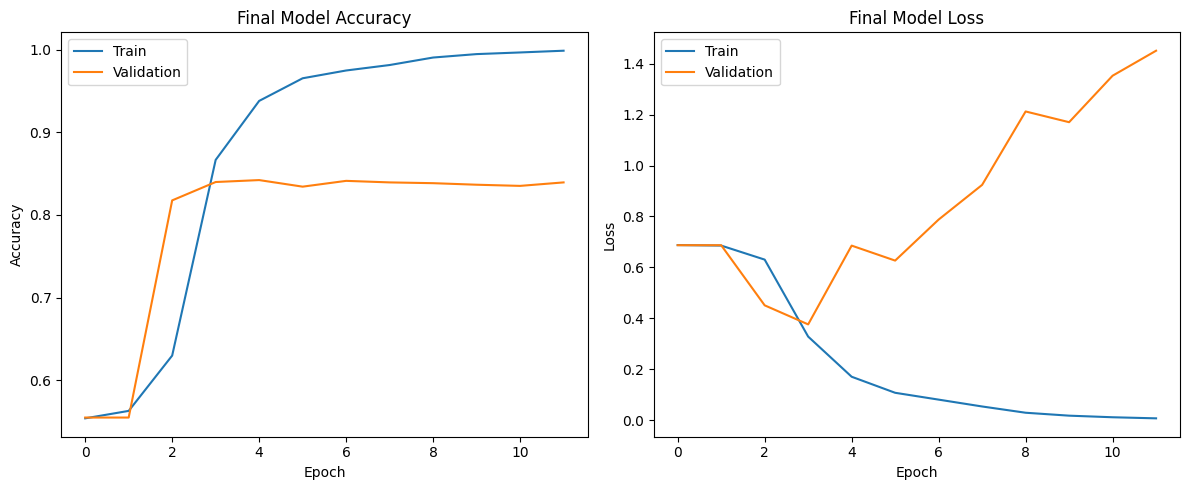

In [32]:
# 14. Final Visualizations for the best model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.title('Final Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('final_sarcasm_deep_rnn_training_metrics.png')
plt.show()

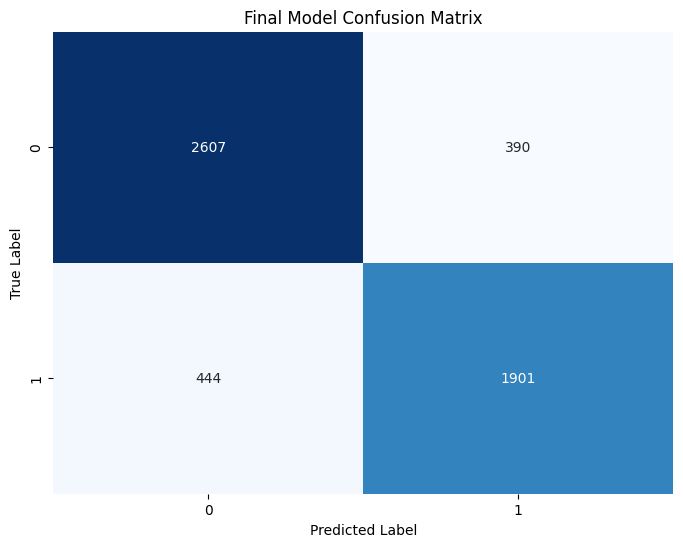

In [33]:
# Final Confusion Matrix
final_cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Final Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('final_sarcasm_deep_rnn_confusion_matrix.png')
plt.show()

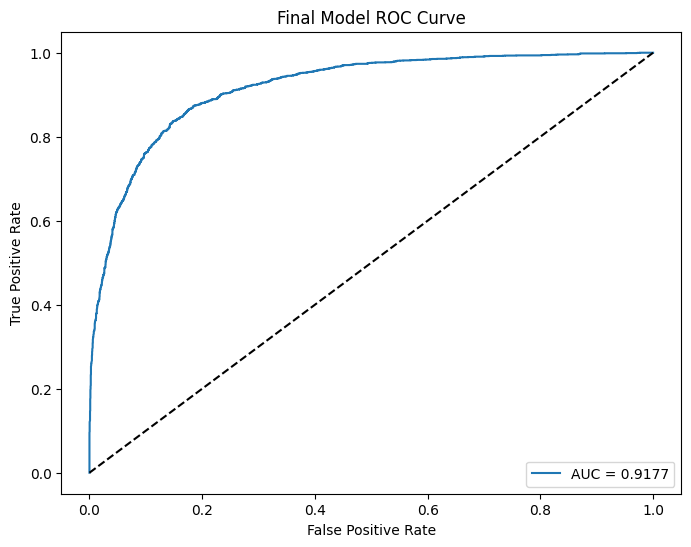

In [34]:
# Final ROC Curve
final_fpr, final_tpr, _ = roc_curve(y_test, y_pred_prob_final)
plt.figure(figsize=(8, 6))
plt.plot(final_fpr, final_tpr, label=f'AUC = {final_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Model ROC Curve')
plt.legend(loc='lower right')
plt.savefig('final_sarcasm_deep_rnn_roc_curve.png')
plt.show()